# 导入包

In [1]:

# 基础的数据处理工具
import numpy as np
import pandas as pd

# 可视化
import matplotlib.pyplot as plt

# 处理python时间函数
import datetime

# 处理nc数据
import netCDF4 as nc
from netCDF4 import num2date

# 处理网格数据，shp之类的
import geopandas as gpd

# 处理tiff文件
import rasterio

# gis的一些逻辑判断
from shapely.geometry import Point

# 设置投影坐标系等
from cartopy import crs as ccrs

# 打印进度条
from tqdm import tqdm

tqdm.pandas()

# 检测系统

import platform

# matplotlib 显示中文的问题
if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

# 加载并且处理数据
## 加载nc文件和读取数据

In [2]:
nc_data = nc.Dataset("cru_ts4.05.1901.2020.tmp.dat.nc")

FileNotFoundError: [Errno 2] No such file or directory: b'cru_ts4.05.1901.2020.tmp.dat.nc'

## 提取变量


In [20]:
raw_lat_data = np.array(nc_data.variables['lat'])
raw_lon_data = np.array(nc_data.variables['lon'])
raw_time_data = np.array(nc_data.variables['time'])
raw_tmp_data = np.array(nc_data.variables['tmp'])

# 变量的缺失值
tmp_missing_value = nc_data.variables['tmp'].missing_value

# 对原始的缺失值做替换，替换成numpy可以识别的缺失值

raw_tmp_data[raw_tmp_data == tmp_missing_value] = np.nan

<ipython-input-20-f53264f80daa>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lat_data = np.array(nc_data.variables['lat'])
<ipython-input-20-f53264f80daa>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_lon_data = np.array(nc_data.variables['lon'])
<ipython-input-20-f53264f80daa>:3: DeprecationWarning: `np.bool` is a deprecated alias f

## 对时间处理

In [10]:
def cftime2datetime(cftime, units, format='%Y-%m-%d %H:%M:%S'):
    """
    将nc文件里面的时间格式 从cftime 转换到 datetime格式
    :param cftime:
    :param units:
    :param format:
    :return:
    """
    return datetime.datetime.strptime(num2date(times=cftime, units=units).strftime(format), format)


clean_time_data = pd.Series([cftime2datetime(i, units='days since 1900-1-1') for i in raw_time_data])
clean_time_data[:4]



0   1901-01-16
1   1901-02-15
2   1901-03-16
3   1901-04-16
dtype: datetime64[ns]

## 处理边界数据

### 导入中国边界数据

In [11]:
china_boundary = gpd.read_file(filename="数据集/中国地图边界202111版.json")

china_boundary_valid = china_boundary.copy()
china_boundary_valid['geometry'] = china_boundary.buffer(0)

In [12]:
china_boundary_valid

,adcode,name,childrenNum,level,parent,geometry
0,100000,中华人民共和国,34,country,{'adcode': None},"MULTIPOLYGON (((110.43346 21.17128, 110.43161 ..."


In [13]:
### 计算相关数据
# 计算中心点
center_china_point = china_boundary_valid.centroid[0]
center_china_point.x, center_china_point.y

<ipython-input-13-adadf07b2796>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_china_point = china_boundary_valid.centroid[0]


(103.87428753932441, 36.42375167335672)

## 设置投影

In [14]:
# 原来的投影系统
raw_crs = china_boundary_valid.crs

# 新的兰伯特投影
new_crs = ccrs.LambertConformal(central_longitude=center_china_point.x,
                                central_latitude=center_china_point.y)

## 基础计算部分

### 计算中国地图点的mask

In [15]:
def pic(lon, lat) -> bool:
    """
    检测一个点是否在中国边界线内
    lon:东经
    lat:北纬
    :param lon:
    :param lat:
    :return:
    """
    return china_boundary_valid.contains(Point(lon, lat))[0]


mask_for_china = np.full(shape=raw_tmp_data.shape[1:], fill_value=False)

for index_lat in tqdm(range(raw_lat_data.shape[0])):
    for index_lon in range(raw_lon_data.shape[0]):
        point = (raw_lon_data[index_lon], raw_lat_data[index_lat])
        mask_for_china[index_lat, index_lon] = pic(point[0], point[1])

100%|██████████| 360/360 [00:55<00:00,  6.47it/s]


In [18]:
mask_for_china

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## 基础函数部分

### 将矩阵保存到tiff文件中

In [19]:
def array2gtiff(array, filename):
    """
    将一个矩阵保存为tiff文件,
    这里还可以设置tiff的crs和transofrm。更多，可以查看rasterio的官网或者下面的这个链接
    https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
    :param array: shape:(row, col)
    :param filename:
    :return:
    """
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=array.shape[0], width=array.shape[1],
                       count=1, dtype=str(array.dtype)) as f:
        f.write(array, 1)


In [22]:
# 保存mask，测试我们的函数都对不对
array2gtiff(array=mask_for_china.astype('float64')[::-1, :],
            filename="结果/test_mask.tiff")

/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


# 需求部分
1. 全世界的年月变化折线图；
2. 中国的年月变化折线图；
3. 全世界年变化折线图；
4. 中国年变化折线图；
5. 全世界每一年的平均数保存为tiff文件；
6. 中国每一年的平均数保存为tiff文件；
7. 特定时间范围内的数据保存为tiff文件（包括中国和全世界两种）
8. 特定时间范围内的且中国范围内的数据求平均数 可视化（使用兰伯特投影）

## 需求1和需求2
1. 全世界的年月变化折线图；
2. 中国的年月变化折线图；

In [33]:
need_1 = pd.DataFrame()
need_1['date'] = clean_time_data

need_1['world_value'] = [np.nanmean(raw_tmp_data[i, :, :]) for i in tqdm(range(raw_tmp_data.shape[0]))]

need_1['china_value'] = [np.nanmean(raw_tmp_data[i, :, :][mask_for_china]) for i in tqdm(range(raw_tmp_data.shape[0]))]
need_1.head()


100%|██████████| 1440/1440 [00:00<00:00, 8110.25it/s]


,date,world_value,china_value
0,1901-01-16,-2.276233,-8.246614
1,1901-02-15,-0.606502,-6.339481
2,1901-03-16,3.036036,0.762672
3,1901-04-16,7.728035,7.624280
4,1901-05-16,12.336250,12.816991


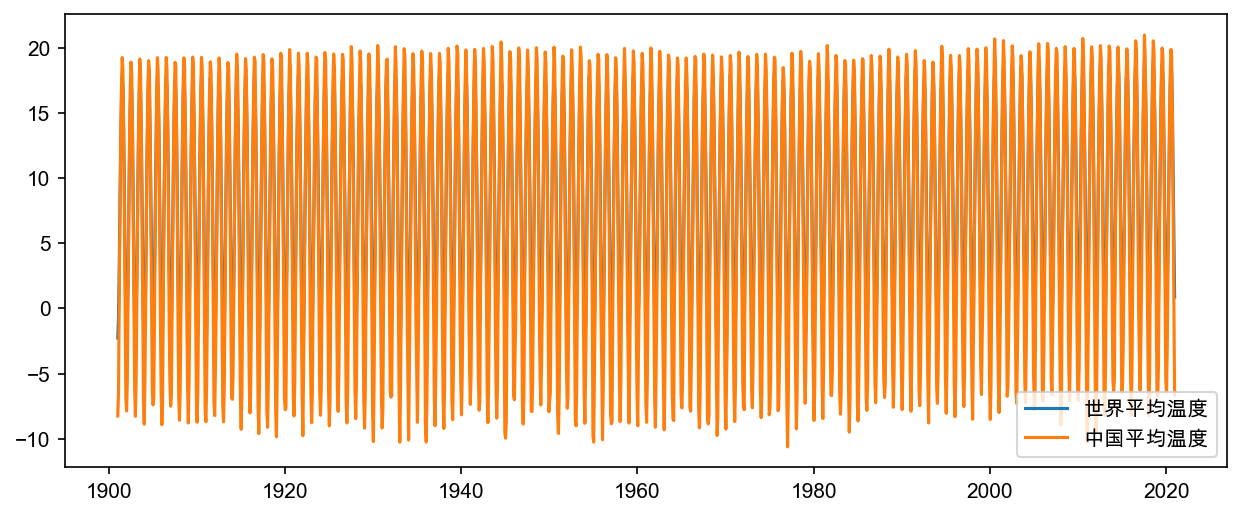

In [35]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
ax.plot(need_1['date'], need_1['world_value'], label='世界平均温度')
ax.plot(need_1['date'], need_1['china_value'], label='中国平均温度')
ax.legend()

## 需求3和4
3. 全世界年变化折线图；
4. 中国年变化折线图；

In [41]:
def cal_need34(year, type):
    out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
    if type == 'world':
        value = np.nanmean(out)
    elif type == 'china':
        value = np.nanmean(out[mask_for_china])
    else:
        value = None
    return value


# test function

cal_need34(year=2001, type='china'), cal_need34(year=2001, type='world')

<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)


(7.204488, 8.862059)

In [43]:
year = np.arange(start=np.min(clean_time_data.dt.year),
                 stop=np.max(clean_time_data.dt.year) + 1)

need_34 = pd.DataFrame({'year': year})
need_34['china_value'] = need_34['year'].apply(lambda x: cal_need34(year=x, type='china'))
need_34['world_value'] = need_34['year'].apply(lambda x: cal_need34(year=x, type='world'))
need_34

<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :,:],axis=0)
<ipython-input-41-be8743db9e53>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[cle

,year,china_value,world_value
0,1901,6.261137,8.029477
1,1902,6.329081,7.642334
2,1903,6.162367,7.813256
3,1904,6.164114,7.759540
4,1905,6.041816,7.875768
...,...,...,...
115,2016,7.544170,9.611753
116,2017,7.718785,9.412547
117,2018,7.351152,9.135641
118,2019,7.618425,9.377328


In [72]:
# % matplotlib
%matplotlib inline

In [49]:
def smooth_data(y_value, deg=4):
    x_new = np.arange(y_value.shape[0])
    new_param = np.polyfit(x_new, y_value, deg=deg)
    value = np.zeros_like(x_new)
    for index, param in enumerate(new_param[::-1]):
        value = value + param * x_new ** index
    return value


need_34['smooth_china_value'] = smooth_data(y_value=need_34['china_value'])
need_34['smooth_world_value'] = smooth_data(y_value=need_34['world_value'])

In [53]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
ax.plot(need_34['year'], need_34['world_value'], label='世界平均温度', linestyle='-', marker='o')
ax.plot(need_34['year'], need_34['china_value'], label='中国平均温度', linestyle='-', marker='o')

# 增加拟合曲线
ax.plot(need_34['year'], need_34['smooth_china_value'], linestyle='--', color='gray')
ax.plot(need_34['year'], need_34['smooth_world_value'], linestyle='--', color='gray')

ax.set_title("每年平均气温")
ax.legend()
ax.set_xlabel("年份")
ax.set_ylabel("温度平均数$ ^\circ C $")
plt.tight_layout()
fig.savefig("结果/每年平均气温.png")

## 需求5和6
5. 全世界每一年的平均数保存为tiff文件；
6. 中国每一年的平均数保存为tiff文件；

In [56]:
def cal_need56(year, type):
    out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
    if type == 'world':
        value = out
    elif type == 'china':
        out[~mask_for_china] = np.nan
        value = out
    else:
        value = None
    return value


out = cal_need56(year=2000, type='china')
array2gtiff(array=out[::-1, :], filename="结果/year2000.tiff")

out = cal_need56(year=2000, type='world')
array2gtiff(array=out[::-1, :], filename="结果/year2000_world.tiff")

<ipython-input-56-aaae6701353d>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
<ipython-input-56-aaae6701353d>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


In [58]:
for temp_year in tqdm(range(np.min(clean_time_data.dt.year), np.max(clean_time_data.dt.year) + 1)):
    out = cal_need56(year=temp_year, type='china')
    array2gtiff(array=out[::-1, :], filename=f"结果/year_{temp_year}_china.tiff")

    out = cal_need56(year=temp_year, type='world')
    array2gtiff(array=out[::-1, :], filename=f"结果/year_{temp_year}_world.tiff")

  0%|          | 0/120 [00:00<?, ?it/s]<ipython-input-56-aaae6701353d>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
<ipython-input-56-aaae6701353d>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,
  1%|          | 1/120 [00:00<00:17,  6.92it/s]<ipython-input-56-aaae6701353d>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[clean_time_data.dt.year == year, :, :], axis=0)
/opt/anaconda3/envs

## 需求7
7. 特定时间范围内的数据保存为tiff文件（包括中国和全世界两种）


In [60]:
def cal_need7(start_date, end_date, type):
    out = np.nanmean(raw_tmp_data[(start_date <= clean_time_data) & (clean_time_data <= end_date), :, :], axis=0)
    if type == 'world':
        value = out
    elif type == 'china':
        out[~mask_for_china] = np.nan
        value = out
    else:
        value = None
    return value

out = cal_need7(start_date='1902-01', end_date='2020-01', type='world')
array2gtiff(array=out[::-1, :], filename="结果/data190201_202001_world.tiff")

out = cal_need7(start_date='1902-01', end_date='2020-01', type='china')
array2gtiff(array=out[::-1, :], filename="结果/data190201_202001_china.tiff")

<ipython-input-60-e2a6f2b451c7>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[(start_date <= clean_time_data) & (clean_time_data <= end_date), :, :], axis=0)
/opt/anaconda3/envs/devc/lib/python3.8/site-packages/rasterio/__init__.py:230: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = writer(path, mode, driver=driver,


## 需求8
8. 特定时间范围内的且中国范围内的数据求平均数 可视化（使用兰伯特投影）

In [61]:
out_8 = cal_need7(start_date='1902-01', end_date='2020-01', type='china')


<ipython-input-60-e2a6f2b451c7>:2: RuntimeWarning: Mean of empty slice
  out = np.nanmean(raw_tmp_data[(start_date <= clean_time_data) & (clean_time_data <= end_date), :, :], axis=0)


In [67]:
Lon_data, Lat_data = np.meshgrid(raw_lon_data, raw_lat_data)

need_8_df = pd.DataFrame({'value':out_8.flatten(),
                          'mask_china':mask_for_china.flatten(),
                          'lon':Lon_data.flatten(),
                          'lat':Lat_data.flatten()})
need_8_df = need_8_df.loc[need_8_df['mask_china']]
need_8_df

,value,mask_china,lon,lat
138816,NaN,True,108.25,6.25
140988,NaN,True,114.25,7.75
144588,NaN,True,114.25,10.25
153223,NaN,True,111.75,16.25
156099,24.815739,True,109.75,18.25
...,...,...,...,...
206524,-5.198447,True,122.25,53.25
206525,-5.604937,True,122.75,53.25
206526,-5.272740,True,123.25,53.25
206527,-4.900280,True,123.75,53.25


In [68]:
need_8_df_gd = gpd.GeoDataFrame(
    need_8_df,
    geometry=gpd.points_from_xy(x=need_8_df['lon'], y=need_8_df['lat']),
    crs= raw_crs#china_boundary.crs
)
need_8_df_gd = need_8_df_gd.to_crs(new_crs.proj4_init)
need_8_df_gd

,value,mask_china,lon,lat,geometry
138816,NaN,True,108.25,6.25,POINT (559728.126 -3501754.659)
140988,NaN,True,114.25,7.75,POINT (1303152.001 -3250214.245)
144588,NaN,True,114.25,10.25,POINT (1267583.115 -2940044.453)
153223,NaN,True,111.75,16.25,POINT (900247.156 -2247899.003)
156099,24.815739,True,109.75,18.25,POINT (656788.893 -2030169.885)
...,...,...,...,...,...
206524,-5.198447,True,122.25,53.25,POINT (1252555.926 2003950.675)
206525,-5.604937,True,122.75,53.25,POINT (1286152.833 2010934.830)
206526,-5.272740,True,123.25,53.25,POINT (1319710.804 2018103.732)
206527,-4.900280,True,123.75,53.25,POINT (1353228.823 2025457.165)


In [70]:
china_boundary_valid_new_crs = china_boundary_valid.to_crs(new_crs.proj4_init)
china_boundary_valid_new_crs

,adcode,name,childrenNum,level,parent,geometry
0,100000,中华人民共和国,34,country,{'adcode': None},"MULTIPOLYGON (((708591.435 -1686525.898, 70831..."


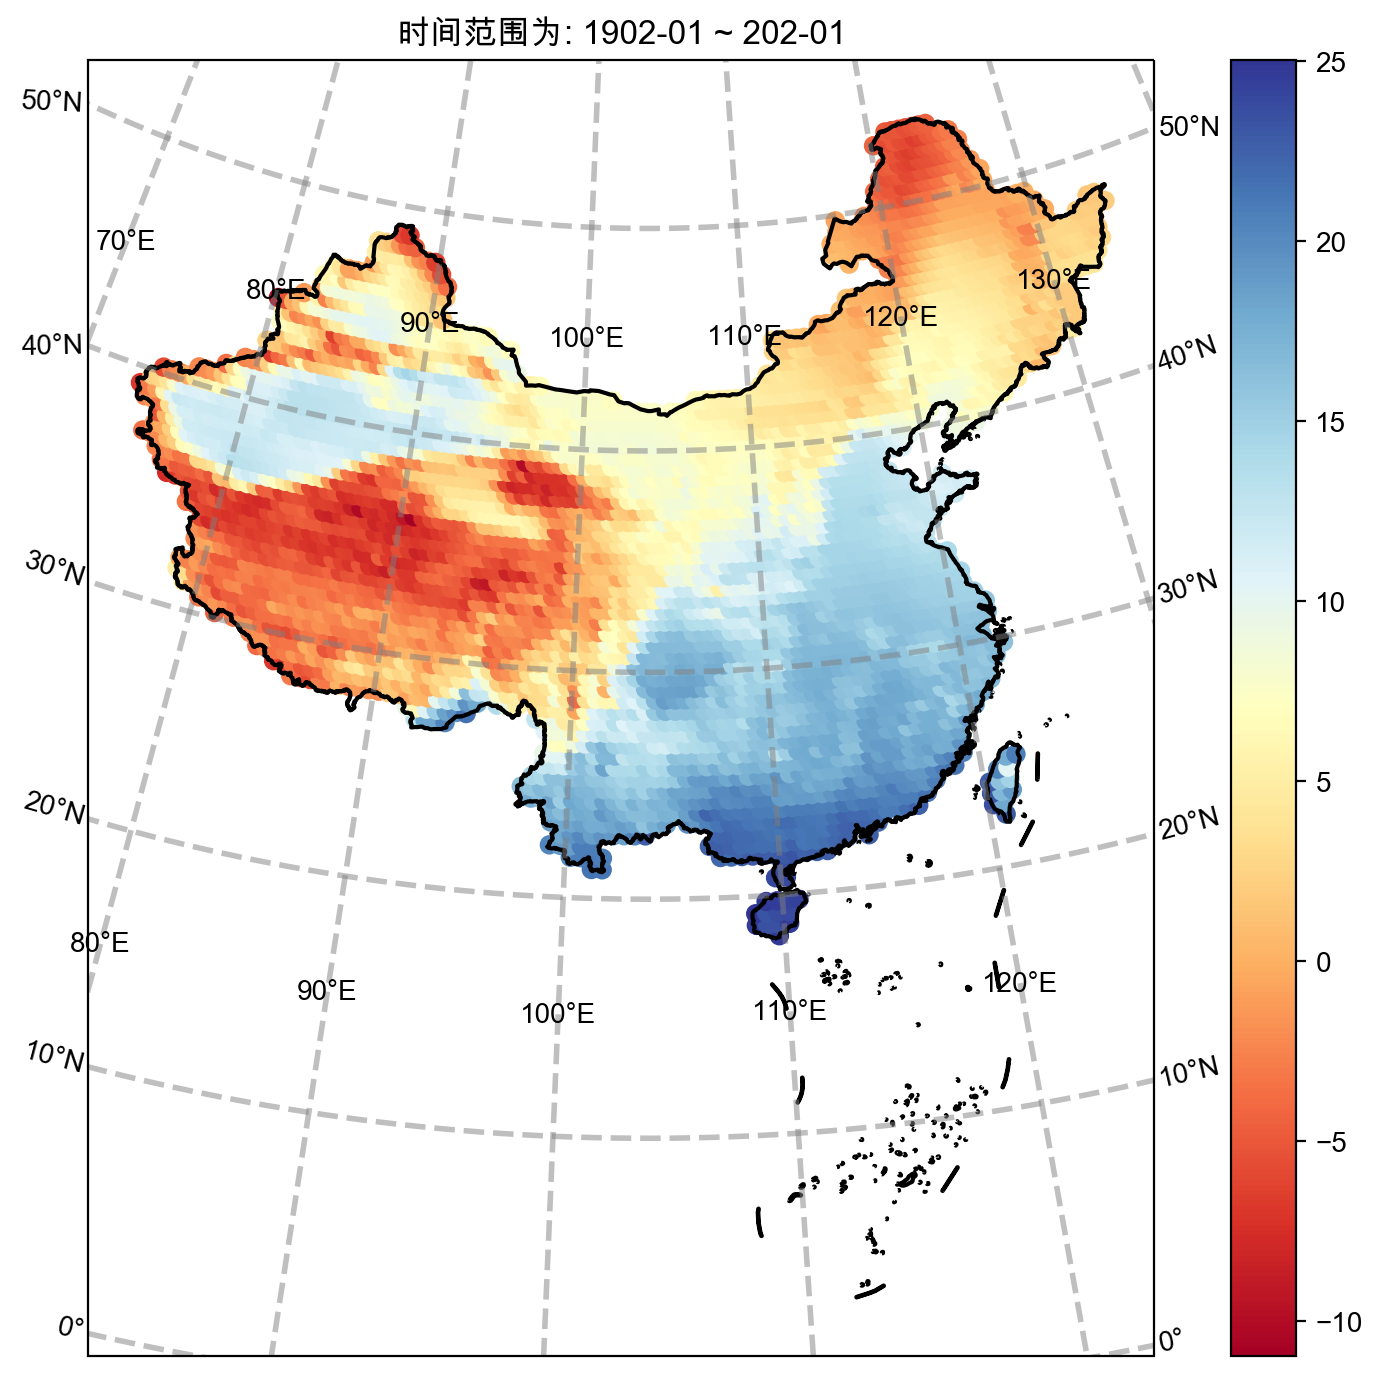

In [73]:
fig, ax = plt.subplots(figsize=(8, 7), dpi=150, subplot_kw={'projection': new_crs})
ax.gridlines(draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')
china_boundary_valid_new_crs.boundary.plot(ax=ax, color='black', marker='s')
need_8_df_gd.plot(ax=ax, column='value', cmap=plt.cm.get_cmap('RdYlBu'), legend=True)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_title(f"时间范围为: 1902-01 ~ 202-01")
plt.tight_layout()

fig.savefig("结果/中国可视化.png")